*Source: https://pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

from face_aligner import FaceAligner

In [2]:
def xywh_to_xyxy(bbox_list):

    '''Convert bounding box from (x, y, w, h) to (x1, y1, x2, y2)'''

    return [(x, y, x+w, y+h) for x, y, w, h in bbox_list]


def draw_bbox_simple(frame, bbox_list):

    '''Draw bounding boxes on the frame, given the list of tuples (x, y, w, h)'''

    for (x1, y1, x2, y2) in bbox_list:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)

    return frame


def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)

	# loop over all facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords


class ResNet10SSDModified:

    '''This class is for the ResNet10 SSD model from OpenCV DNN module.'''

    def __init__(self, config_path='input/deploy.prototxt.txt', model_path='input/res10_300x300_ssd_iter_140000.caffemodel'):

        self.net = cv2.dnn.readNetFromCaffe(config_path, model_path)

    def detect_faces(self, frame, w, h, score=0.5):

        blob = cv2.dnn.blobFromImage(frame, 1.0, (300,300), (104.0,117.0,123.0))
        self.net.setInput(blob)
        faces = self.net.forward()
        bbox_list = []

        # faces is 4-d array (1, 1, 200, 7)
        # last dim: 1: class_id, 2: score, 3-6: boxes
        for i in range(faces.shape[2]):
            confidence = faces[0, 0, i, 2]
            if confidence > score:
                bbox = (faces[0, 0, i, 3:7] * np.array([w, h, w, h])).astype('int')
                bbox_list.append(bbox)

        return bbox_list

In [3]:
face_det = ResNet10SSDModified()
predictor = dlib.shape_predictor('input/shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredLeftEye=(0.25, 0.35), desiredFaceWidth=75, desiredFaceHeight=100)

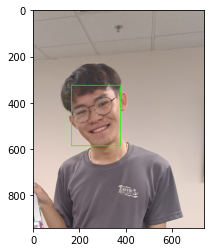

In [4]:
frame = cv2.imread('input/test-images/wy.jpg')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

bbox_list = face_det.detect_faces(frame, w=frame.shape[1], h=frame.shape[0])

frame_draw = frame.copy()
draw_bbox_simple(frame_draw, bbox_list)
plt.imshow(frame_draw[..., ::-1]);
# plt.axis('off');

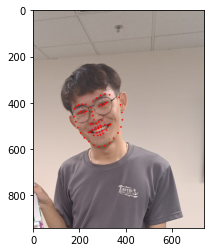

In [5]:
x1, y1, x2, y2 = bbox_list[0]
shape = predictor(gray, dlib.rectangle(x1, y1, x2, y2))
shape = shape_to_np(shape)

frame_draw = frame.copy()
for (x, y) in shape:
    cv2.circle(frame_draw, (x, y), 2, (0, 0, 255), 4)

plt.imshow(frame_draw[..., ::-1]);
# plt.axis('off');

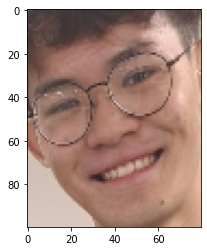

In [6]:
x1, y1, x2, y2 = bbox_list[0]
face = frame[y1:y2, x1:x2]
face = cv2.resize(face, (80, 100))

plt.imshow(face[..., ::-1]);
# plt.axis('off');

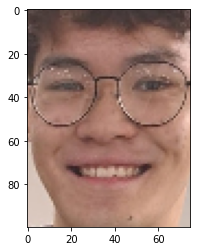

In [7]:
x1, y1, x2, y2 = bbox_list[0].astype(int)
faceAligned = fa.align(frame, gray, dlib.rectangle(x1, y1, x2, y2))

plt.imshow(faceAligned[..., ::-1]);
# plt.axis('off');